In [1]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.7 MB/s eta 0:00:00:00:0100:01


In [2]:
pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 40.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
random.seed(42) 

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-human-gut-biotransformation-pathways/test.csv
/kaggle/input/prediction-human-gut-biotransformation-pathways/archive/sample_submission.csv
/kaggle/input/prediction-human-gut-biotransformation-pathways/archive/train.csv
/kaggle/input/prediction-human-gut-biotransformation-pathways/archive/test_demo.csv


In [4]:
test_df = pd.read_csv('/archive/test_demo.csv')
test_df

,PWY_ID,Steps,Compound
0,pwy0001,8,NC(Cc1ccc(O)cc1)C(=O)O


In [5]:
train_df = pd.read_csv('/archive/train.csv')
train_df[['Reactant', 'Product']] = train_df['SMILE'].str.split('>>', expand=True)
train_df = train_df.drop_duplicates(subset=['Reactant', 'Product']).reset_index(drop=True)
print (len(train_df))

17320


In [6]:
def is_valid_smiles(smiles):
    return Chem.MolFromSmiles(smiles) is not None

train_df = train_df[train_df['Reactant'].apply(is_valid_smiles) & train_df['Product'].apply(is_valid_smiles)].reset_index(drop=True)
print (len(train_df))

17320


In [7]:
print("Number of unique reactants:", train_df['Reactant'].nunique())
print("Number of unique products:", train_df['Product'].nunique())

Number of unique reactants: 7656
Number of unique products: 7998


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


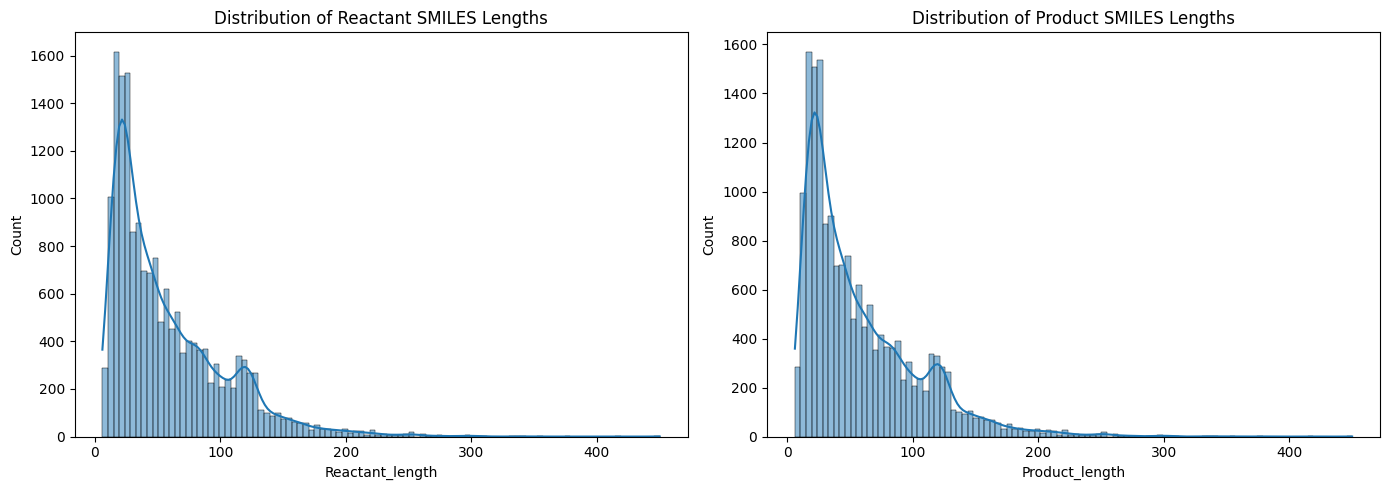

In [8]:
train_df['Reactant_length'] = train_df['Reactant'].apply(len)
train_df['Product_length'] = train_df['Product'].apply(len)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_df['Reactant_length'], ax=axs[0], kde=True)
axs[0].set_title("Distribution of Reactant SMILES Lengths")

sns.histplot(train_df['Product_length'], ax=axs[1], kde=True)
axs[1].set_title("Distribution of Product SMILES Lengths")

plt.tight_layout()
plt.show()

In [9]:
display(train_df.head(10))

,ID,SMILE,Reactant,Product,Reactant_length,Product_length
0,ID0000001,CC(=O)NC(CC(=O)O)C(=O)O>>CC(=O)NC(CC(=O)O)C(=O...,CC(=O)NC(CC(=O)O)C(=O)O,CC(=O)NC(CC(=O)O)C(=O)NC(CCC(=O)O)C(=O)NC(CCC(...,23,57
1,ID0000002,NCCc1ccc(O)cc1>>O=CCc1ccc(O)cc1,NCCc1ccc(O)cc1,O=CCc1ccc(O)cc1,14,15
2,ID0000003,*C(NC(=O)CC1CCC(=O)C1C/C=C\CC(=O)O)C(=O)O>>*C(...,*C(NC(=O)CC1CCC(=O)C1C/C=C\CC(=O)O)C(=O)O,*C(NC(=O)CC1CCC(=O)C1C/C=C\CC=O)C(=O)O,41,38
3,ID0000004,CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O[C...,CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O[C...,CC(=O)N[C@H]1C(O)O[C@H](CO)[C@@H](O)[C@@H]1O[C...,84,119
4,ID0000005,OC[C@H]1O[C@@H]2OC[C@H]3O[C@H](O[C@@H]4[C@@H](...,OC[C@H]1O[C@@H]2OC[C@H]3O[C@H](O[C@@H]4[C@@H](...,OC[C@H]1O[C@H](OC[C@H]2OC(O)[C@H](O)[C@@H](O)[...,163,79
5,ID0000006,O=C(O)c1cccc(C(=O)CC[C@H]2O[C@@H](n3cnc4c(=O)[...,O=C(O)c1cccc(C(=O)CC[C@H]2O[C@@H](n3cnc4c(=O)[...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CCC(=O)c2cccc(C(=O...,74,68
6,ID0000007,CC(CO)(c1ccc(O)cc1)c1ccc(O)cc1>>CC(C)(c1ccc(O)...,CC(CO)(c1ccc(O)cc1)c1ccc(O)cc1,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,30,29
7,ID0000008,*C(=O)N[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H...,*C(=O)N[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H...,*C(=O)N[C@@H](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H...,230,188
8,ID0000009,*OP(=O)(O)OC[C@H]1O[C@@H](*)C[C@@H]1OP(=O)(O)O...,*OP(=O)(O)OC[C@H]1O[C@@H](*)C[C@@H]1OP(=O)(O)O...,*OP(=O)(O)O[C@H]1C[C@H](*)O[C@@H]1COP(=O)(O)O,117,45
9,ID0000010,NP(=O)(OCCC=O)N(CCCl)CCCl>>O=P1(N(CCCl)CCCl)NC...,NP(=O)(OCCC=O)N(CCCl)CCCl,O=P1(N(CCCl)CCCl)NC(O)CCO1,25,26


Data Preprocessing. Code was created by Kaggle user Poma Mikhail

In [10]:
# Function to extract reaction SMARTS from reactant and product
def extract_reaction_smarts(reactant_smiles, product_smiles):
    reactant_mol = Chem.MolFromSmiles(reactant_smiles)
    product_mol = Chem.MolFromSmiles(product_smiles)
    rxn = rdChemReactions.ReactionFromSmarts(f"{Chem.MolToSmarts(reactant_mol)}>>{Chem.MolToSmarts(product_mol)}")
    return rxn

# Extract reaction templates
reaction_templates = []
for idx, row in train_df.iterrows():
    try:
        rxn = extract_reaction_smarts(row['Reactant'], row['Product'])
        reaction_templates.append(rxn)
    except:
        continue

# Remove duplicate templates
unique_templates = []
seen_templates = set()
for rxn in reaction_templates:
    smarts = rdChemReactions.ReactionToSmarts(rxn)
    if smarts not in seen_templates:
        unique_templates.append(rxn)
        seen_templates.add(smarts)

In [11]:
test_df = pd.read_csv('test.csv')

In [12]:
len(test_df)
display(test_df.head(10))

,PWY_ID,Steps,Compound
0,pwy0001,8,NC(Cc1ccc(O)cc1)C(=O)O
1,pwy0002,5,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...
2,pwy0003,6,O=C(O)C=Cc1ccc(O)cc1
3,pwy0004,3,NC(Cc1ccccc1)C(=O)O
4,pwy0005,6,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...
5,pwy0006,3,O=C(C=Cc1ccc(O)cc1)c1c(O)cc(O)cc1O
6,pwy0007,4,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
7,pwy0008,4,O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
8,pwy0009,4,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12
9,pwy0010,4,Oc1cc(O)c2cc(O)c(-c3ccc(O)c(O)c3)[o+]c2c1


Following code was created by Kaggle user Poma Mikhail 

In [13]:
def apply_reaction_templates(mol_smiles, templates):
    # Convert the SMILES string to an RDKit molecule object
    if isinstance(mol_smiles, rdkit.Chem.rdchem.Mol):
        mol = mol_smiles
    else:
        mol = Chem.MolFromSmiles(mol_smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {mol_smiles}")

    products = set()
    for rxn in templates:
        ps = rxn.RunReactants((mol,))
        for p in ps:
            prod_mol = p[0]
            try:
                Chem.SanitizeMol(prod_mol, catchErrors=True)
                prod_smiles = Chem.MolToSmiles(prod_mol, isomericSmiles=True)
                products.add(prod_smiles)
            except Exception as e:
                print(f"Error sanitizing product molecule: {e}")
                continue
    return list(products)

# Function to generate pathways recursively
def generate_pathways(start_smiles, steps, templates, max_paths=5):
    pathways = []
    queue = [([start_smiles], 0)]
    visited = set()
    while queue and len(pathways) < max_paths:
        print ("len queue", len(queue))
        print ("len pathways", len(pathways))
        current_path, depth = queue.pop(0)
        if depth == steps:
            pathways.append(current_path[1:])  # Exclude the starting compound
            continue
        last_smiles = current_path[-1]
        mol = Chem.MolFromSmiles(last_smiles)
        if mol is None:
            continue
        products = apply_reaction_templates(mol, templates)
        for prod_smiles in products:
            if prod_smiles in current_path:
                continue  # Avoid cycles
            queue.append((current_path + [prod_smiles], depth + 1))
    return pathways

In [14]:
def generate_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((n_bits,))
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits))

In [15]:
X = []
y = []

for idx, row in train_df.iterrows():
    reactant_fp = generate_fingerprint(row['Reactant'])
    product_fp = generate_fingerprint(row['Product'])
    reaction_fp = np.concatenate([reactant_fp, product_fp])
    X.append(reaction_fp)
    y.append(row['Product'])

X = np.array(X)
y = np.array(y)

In [16]:
# Remove constant features
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
X = selector.fit_transform(X)

# Normalize features to allow for faster model training
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.array(y)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Performing Feature Selection to improve training speeds

In [17]:
common_labels = np.intersect1d(y_train, y_val)

train_mask = np.isin(y_train, common_labels)
val_mask = np.isin(y_val, common_labels)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_val = X_val[val_mask]
y_val = y_val[val_mask]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

variance_filter = VarianceThreshold(threshold=0.0)
X_train_filtered = variance_filter.fit_transform(X_train)
X_val_filtered = variance_filter.transform(X_val)

selector = SelectKBest(f_classif, k=min(500, X_train_filtered.shape[1]))
X_train_reduced = selector.fit_transform(X_train_filtered, y_train)
X_val_reduced = selector.transform(X_val_filtered)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


**Training Random Forest Model**

In [18]:
randomForestModel = RandomForestClassifier(n_estimators=100, random_state=42)
randomForestModel.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred_random_forest = randomForestModel.predict(X_val_reduced)
print("Accuracy:", accuracy_score(y_val, y_pred_random_forest))
print("F1 Score:", f1_score(y_val, y_pred_random_forest, average='weighted'))

Accuracy: 0.7855164226355362
F1 Score: 0.7365284432960275


In [20]:
randomForestModel = RandomForestClassifier(n_estimators=200, random_state=42)
randomForestModel.fit(X_train_reduced, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [21]:
y_pred_random_forest = randomForestModel.predict(X_val_reduced)
print("Accuracy:", accuracy_score(y_val, y_pred_random_forest))
print("F1 Score:", f1_score(y_val, y_pred_random_forest, average='weighted'))

Accuracy: 0.7859121487930352
F1 Score: 0.7371349093358137


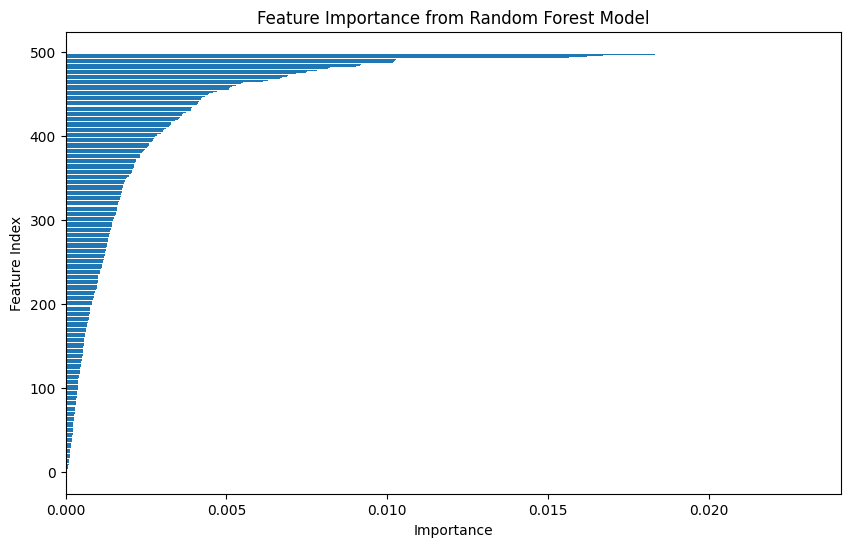

In [22]:
importances = randomForestModel.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.title("Feature Importance from Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature Index")
plt.show()

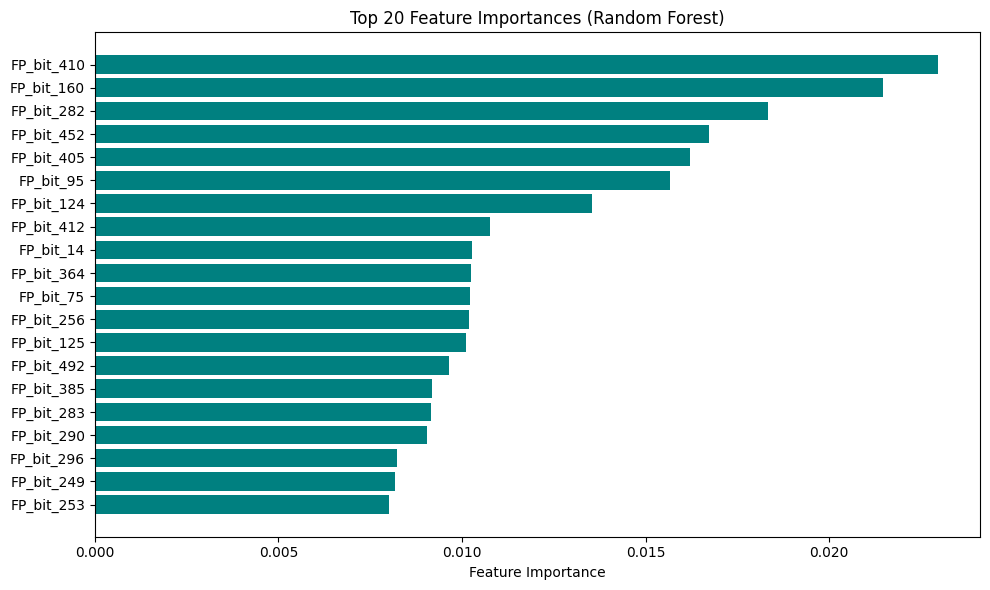

In [23]:
feature_names = [f"FP_bit_{i}" for i in range(X_train_reduced.shape[1])]

importances = randomForestModel.feature_importances_
sorted_idx = np.argsort(importances)

top_n = 20
top_features_indices = sorted_idx[-top_n:]
top_features = [feature_names[i] for i in top_features_indices]
top_importances = importances[top_features_indices]

plt.figure(figsize=(10,6))
plt.barh(top_features, top_importances, color='teal')
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

**Training LightGBM model**

In [24]:
clf = LGBMClassifier(n_estimators=50,max_depth=5,num_leaves=32,max_bin=64,learning_rate=0.01,n_jobs=-1,verbosity=-1,random_state=42)
clf.fit(X_train_reduced, y_train, eval_set=[(X_val_reduced, y_val)], eval_metric='logloss')

LGBMClassifier(learning_rate=0.01, max_bin=64, max_depth=5, n_estimators=50,
               n_jobs=-1, num_leaves=32, random_state=42, verbosity=-1)

In [25]:
y_pred_LGBM = clf.predict(X_val_reduced)
print("Accuracy:", accuracy_score(y_val, y_pred_LGBM))
print("F1 Score:", f1_score(y_val, y_pred_LGBM, average='weighted'))

Accuracy: 0.7107241788682231
F1 Score: 0.6498877034018843


**Comparing Robustness of Random Forest and LightGBM Models**

/tmp/ipykernel_30/874623414.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_per_class['Accuracy_RF'], shade=True, color='blue', label='Random Forest with 200 Estimators')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_30/874623414.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_per_class['Accuracy_LGB'], shade=True, color='green', label='LightGBM')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versio

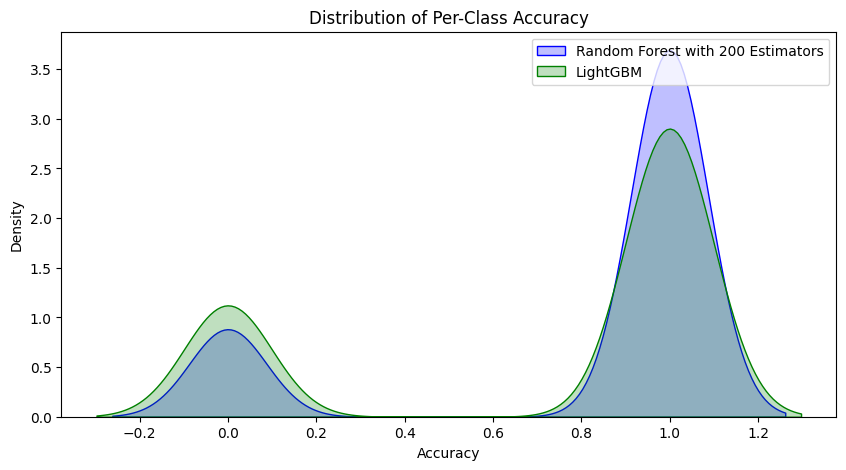

In [26]:
unique_classes = np.unique(y_val)
class_accuracies_rf = []
class_accuracies_lgb = []
class_frequencies = []

for cls in unique_classes:
    cls_mask = (y_val == cls)
    cls_true = y_val[cls_mask]
    cls_pred_rf = y_pred_random_forest[cls_mask]
    cls_pred_lgb = y_pred_LGBM[cls_mask]
    
    class_accuracy_rf = accuracy_score(cls_true, cls_pred_rf)
    class_accuracy_lgb = accuracy_score(cls_true, cls_pred_lgb)
    
    class_accuracies_rf.append(class_accuracy_rf)
    class_accuracies_lgb.append(class_accuracy_lgb)
    class_frequencies.append(cls_mask.sum())

df_per_class = pd.DataFrame({
    'Class': unique_classes,
    'Frequency': class_frequencies,
    'Accuracy_RF': class_accuracies_rf,
    'Accuracy_LGB': class_accuracies_lgb
})

plt.figure(figsize=(10,5))
sns.kdeplot(df_per_class['Accuracy_RF'], shade=True, color='blue', label='Random Forest with 200 Estimators')
sns.kdeplot(df_per_class['Accuracy_LGB'], shade=True, color='green', label='LightGBM')
plt.title("Distribution of Per-Class Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.legend()
plt.show()

**Confusion Matrix for Random Forest Model**

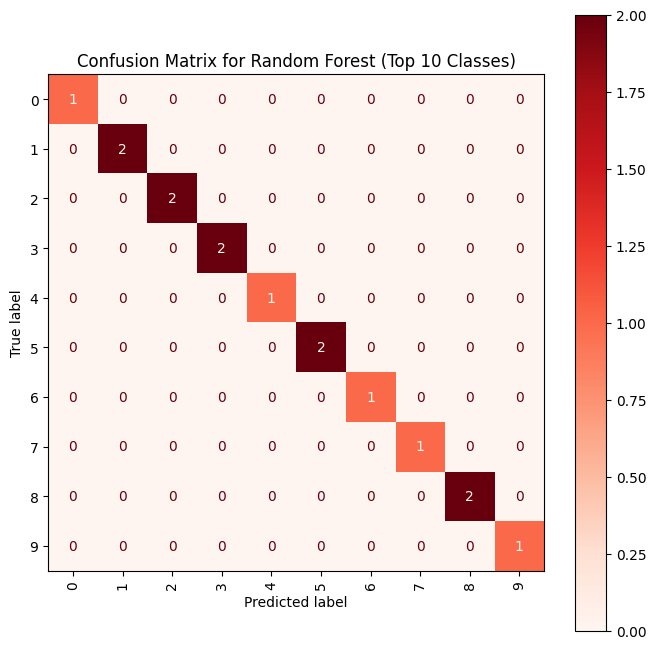

In [27]:
top_n = 10
top_classes = df_per_class.head(top_n)['Class'].values

mask_top = np.isin(y_val, top_classes)
top_y_val = y_val[mask_top]
top_y_pred_rf = y_pred_random_forest[mask_top]

class_mapping = {cls: i for i, cls in enumerate(top_classes)}
mapped_y_val = np.array([class_mapping[c] for c in top_y_val])
mapped_y_pred_rf = np.array([class_mapping[c] for c in top_y_pred_rf])

cm_top_rf = confusion_matrix(mapped_y_val, mapped_y_pred_rf, labels=range(top_n))

fig, ax = plt.subplots(figsize=(8,8))
disp_top_rf = ConfusionMatrixDisplay(confusion_matrix=cm_top_rf, display_labels=top_classes)
disp_top_rf.plot(ax=ax, xticks_rotation='vertical', cmap='Reds')
plt.title(f"Confusion Matrix for Random Forest (Top {top_n} Classes)")
plt.show()


**Confusion Matrix for LightGBM Model**

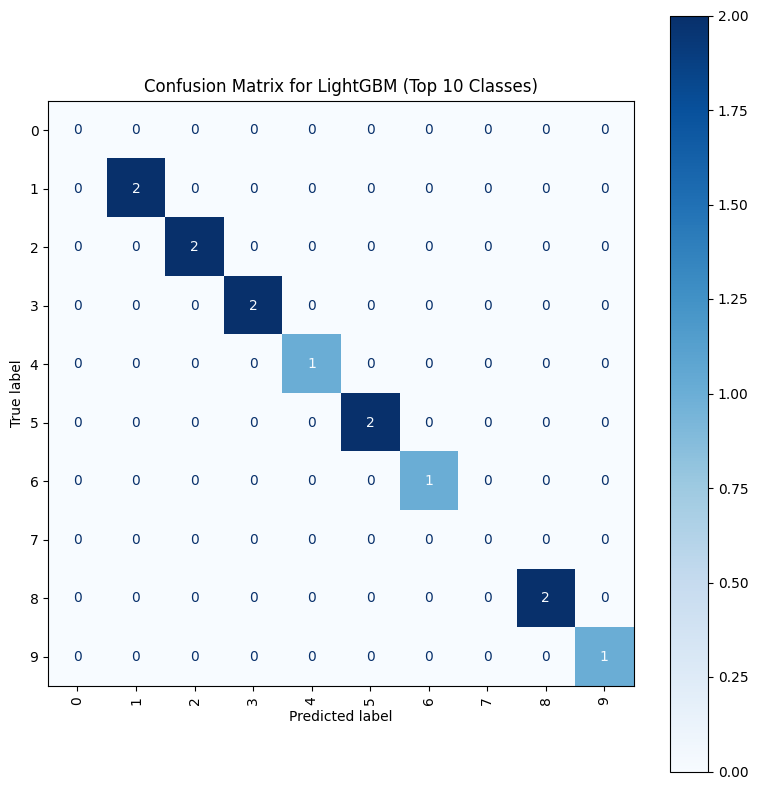

In [28]:
top_n = 10
top_classes = df_per_class.head(top_n)['Class'].values

mask_top = np.isin(y_val, top_classes)
top_y_val = y_val[mask_top]
top_y_pred_lgbm = y_pred_LGBM[mask_top]

mask_pred_top = np.isin(top_y_pred_lgbm, top_classes)
top_y_val_lgbm = top_y_val[mask_pred_top]
top_y_pred_lgbm = top_y_pred_lgbm[mask_pred_top]

class_mapping = {cls: i for i, cls in enumerate(top_classes)}
mapped_y_val = np.array([class_mapping[c] for c in top_y_val_lgbm])
mapped_y_pred_lgbm = np.array([class_mapping[c] for c in top_y_pred_lgbm])

cm_top_lgbm = confusion_matrix(mapped_y_val, mapped_y_pred_lgbm, labels=range(top_n))

fig, ax = plt.subplots(figsize=(8,8))
disp_top_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_top_lgbm, display_labels=top_classes)
disp_top_lgbm.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title(f"Confusion Matrix for LightGBM (Top {top_n} Classes)")
plt.tight_layout()
plt.show()